# Quant GAN
## Torch Verison
[Wiese et al., Quant GANs: Deep Generation of Financial Time Series, 2019](https://arxiv.org/abs/1907.06673)

In [1]:
#%%capture
import os, sys
file_name = 'ShanghaiSE_daily'  # 'ShanghaiSE_daily' or 'SP500_daily'
colab = 'COLAB_GPU' in os.environ
file_path = f'./data/{file_name}.csv'
generator_path = f'./trained/'
if colab:
	from google.colab import files
	!pip install torch
	file_path = f'/content/temporalCN/data/{file_name}.csv'
	generator_path = f'/content/temporalCN/trained/'
	username = "JamesSullivan"
	repository = "temporalCN"
	!git clone https://github.com/{username}/{repository}.git
	sys.path.append('/content/temporalCN/')

Cloning into 'temporalCN'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 29 (delta 1), reused 29 (delta 1), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from preprocess.acf import *
from preprocess.gaussianize import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.torch_tcn import *


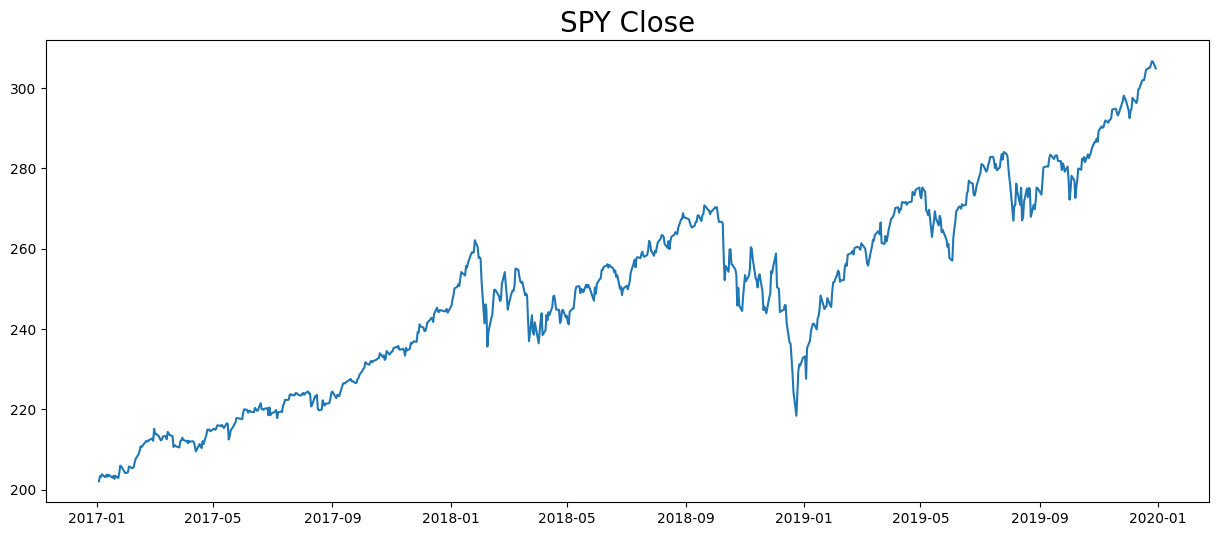

In [13]:
def dateparse(d):
    return pd.Timestamp(d)

file_name = 'SPY'
file_path = f'./data/{file_name}.csv'
generator_path = './trained/spy/'

data = pd.read_csv(file_path, parse_dates={'datetime': ['Date']}, date_parser=dateparse)
fig = plt.figure(figsize=(15,6))
plt.title(f'{file_name} Close', fontsize=20)
plt.plot(data['datetime'], data['Adj Close'] )
plt.show()
# confirm data loaded

In [14]:
## Options Plot

'''
def dateparse(d):
    return pd.Timestamp(d)

file_name = 'spx_eod_202204'
file_path = f'./data/spx_eod_2022/{file_name}.csv'
data = pd.read_csv(file_path, parse_dates={'datetime': ['[QUOTE_DATE]']}, date_parser=dateparse)
df = data['[C_LAST]']
fig = plt.figure(figsize=(15,6))
plt.title(f'{file_name} Call Last', fontsize=20)
plt.plot(data['datetime'], data['[C_LAST]'] )
plt.show()
# confirm data loaded

'''

"\ndef dateparse(d):\n    return pd.Timestamp(d)\n\nfile_name = 'spx_eod_202204'\nfile_path = f'./data/spx_eod_2022/{file_name}.csv'\ndata = pd.read_csv(file_path, parse_dates={'datetime': ['[QUOTE_DATE]']}, date_parser=dateparse)\ndf = data['[C_LAST]']\nfig = plt.figure(figsize=(15,6))\nplt.title(f'{file_name} Call Last', fontsize=20)\nplt.plot(data['datetime'], data['[C_LAST]'] )\nplt.show()\n# confirm data loaded\n\n"

In [15]:
data.columns

Index(['datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [16]:
# Get 5 columns of the dataset. Exclude 'Close'
data.shape
df = data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
df.head()

,Open,High,Low,Adj Close,Volume
0,225.039993,225.830002,223.880005,202.085266,91366500
1,225.619995,226.750000,225.610001,203.287506,78744400
2,226.270004,226.580002,225.479996,203.125992,78379000
3,226.529999,227.750000,225.899994,203.852722,71559900
4,226.910004,227.070007,226.419998,203.179855,46939700


## Preprocess data
 For more details see [preprocess.ipynb](./preprocess.ipynb)

In [6]:
class Loader32(Dataset):
    
    def __init__(self, data, length):
        assert len(data) >= length
        self.data = data
        self.length = length
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32)
        
    def __len__(self):
        return max(len(self.data)-self.length, 0)

returns = df.shift(1)/df - 1
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
receptive_field_size = 127  # p. 17
data_size = log_returns.shape[0]
print(log_returns_preprocessed.shape)
print(data_size)

(3760, 1)
3760


In [17]:
np.log(df['Adj Close']/df['Adj Close'].shift(1))[1:].to_numpy().reshape(-1, 1).shape

(752, 1)

### Preprocess Data For more than 1 feature

In [18]:
## For more than 1 feature

class Loader32(Dataset):
    
    def __init__(self, data, length):
        assert len(data) >= length
        self.data = data
        self.length = length
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32)
        
    def __len__(self):
        return max(len(self.data)-self.length, 0)

log_returns = np.log(df['Adj Close']/df['Adj Close'].shift(1))[1:].to_numpy().reshape(-1, 1)
df = df[1:]
# Add the 6th column log_returns
df['log_returns'] = log_returns

standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
df = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(df)))
receptive_field_size = 127  # p. 17
#data_size = log_returns.shape[0]
#print(log_returns_preprocessed.shape)
print(df.shape)

(752, 6)


In [19]:
df[:5]

array([[-1.96244483, -1.95400115, -1.91589346, -1.86930441,  0.12073515,
         0.91381085],
       [-1.93372238, -1.9614868 , -1.92166726, -1.87589027,  0.10562737,
        -0.30896464],
       [-1.92223377, -1.90996737, -1.90301424, -1.84625727, -0.17677885,
         0.53136081],
       [-1.9054422 , -1.93991003, -1.87991974, -1.87369397, -1.05837935,
        -0.75249361],
       [-1.9244433 , -1.92317764, -1.89812886, -1.87369397, -0.48763758,
        -0.15504797]])

In [23]:
df[:10]
returns[:10]
log_returns_preprocessed[:10]

NameError: name 'returns' is not defined

## Train model
 For more details see [torch_model.ipynb](./torch_model.ipynb)

In [20]:
num_epochs = 10000
if df.shape[1] > 1:
  nz = df.shape[1]
  n_features = True
else:
  nz = 3
  n_features = False
batch_size = 64
seq_len = 127
clip= 0.01
lr = 0.0002

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

device = torch.device(dev) 

In [21]:
torch.cuda.is_available()

True

In [26]:
noise = torch.randn(batch_size, nz, seq_len, device=device)
noise.shape

torch.Size([64, 6, 127])

In [12]:
import torch.optim as optim
from tqdm import tqdm

if n_features == True:
    file_name = 'SPY'
    file_path = f'./data/{file_name}.csv'
    generator_path = './trained/spy_all_features/'


generator = Generator().to(device)

train = True

if train:
    discriminator = Discriminator(batch_size, seq_len).to(device)
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
    gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)

    dataset = Loader32(df, seq_len)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    dataset = Loader32(df, 1)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    t = tqdm(range(num_epochs))
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):

            discriminator.zero_grad()
            real = data.to(device)
            batch_size, seq_len = real.size(0), real.size(1)
            noise = torch.randn(batch_size, nz, seq_len, device=device)
            fake = generator(noise).detach()
            #print('Here', fake.shape, generator(noise).shape)
            disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
            disc_loss.backward()
            disc_optimizer.step()

            for dp in discriminator.parameters():
                dp.data.clamp_(-clip, clip)
    
            if idx % 5 == 0:
                generator.zero_grad()
                gen_loss = -torch.mean(discriminator(generator(noise)))
                gen_loss.backward()
                gen_optimizer.step()            
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f'{generator_path}trained_generator_{file_name}_epoch_{epoch}.pth')

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()

Discriminator Loss: -0.00011164 Generator Loss: -0.49990901: 100%|██████████| 10000/10000 [1:50:41<00:00,  1.51it/s]


In [23]:
if n_features == True:
    file_name = 'SPY'
    file_path = f'./data/{file_name}.csv'
    generator_path = './trained/spy_all_features/'

print(generator_path)
generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
generator.eval()

./trained/spy_all_features/


Generator(
  (tcn): ModuleList(
    (0): TemporalBlock(
      (conv1): Conv1d(6, 80, kernel_size=(1,), stride=(1,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(80, 80, kernel_size=(1,), stride=(1,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(6, 80, kernel_size=(1,), stride=(1,))
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Conv1d(80, 80, kernel_size=(1,), stride=(1,))
        (4): ReLU()
        (5): Dropout(p=0.2, inplace=False)
      )
      (downsample): Conv1d(6, 80, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(80, 80, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(80, 80, kernel_size=(2,), stride=(1,), padding

In [28]:
# Save
#torch.save(generator, f'{generator_path}trained_generator_{file_name}_epoch_{epoch}.pth')
df.shape

(752, 6)

In [27]:
## For 1 feature
import random
random_ind, random_ind2 = random.randrange(0,log_returns_preprocessed.shape[0]-128), random.randrange(0,log_returns_preprocessed.shape[0]-128)
log_returns_preprocessed_test = log_returns_preprocessed[random_ind:random_ind+127]
test_against_itself = log_returns_preprocessed[random_ind2:random_ind2+127]
print(random_ind, random_ind2, log_returns_preprocessed_test.shape, test_against_itself.shape)

NameError: name 'log_returns_preprocessed' is not defined

In [29]:
## For all features
import random
random_ind, random_ind2 = random.randrange(0,df.shape[0]-128), random.randrange(0,df.shape[0]-128)
df_test = df[random_ind:random_ind+127]
df_test_against_itself = df[random_ind2:random_ind2+127]
print(random_ind, random_ind2, df_test.shape, df_test_against_itself.shape, type(df_test))

349 16 (127, 6) (127, 6) <class 'numpy.ndarray'>


## Generate

In [27]:
# Generate for all features

if n_features == True:
    file_name = 'SPY'
    file_path = f'./data/{file_name}.csv'
    generator_path = './trained/spy_all_features/'

## If generator not defined, i.e to load it.
generator = Generator().to(device)
generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')

generator.eval()
noise = torch.randn(50,df.shape[1],127).to(device)
y = generator(noise).cpu().detach().squeeze()

print(f'checking y: f{y.shape}')

'''
#y = y.T
y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
#print(z.shape)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)
print(f'checking y: f{y.shape}')
'''

'''
print(f'checking y: f{y.shape}')
# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
'''

len(y)


checking y: ftorch.Size([50, 6, 127])


50

In [28]:
# Save the numpy array with all 50 generated paths
with open('trained/generated/allFeature50paths.npy', 'wb') as f:
    np.save(f, y)

In [68]:
# Trasform to df_test & df_test_against_itself
df_test = (df_test - df_test.mean(axis=0))/df_test.std(axis=0)
df_test = standardScaler2.inverse_transform(df_test)
df_test = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in df_test]).squeeze()
df_test = standardScaler1.inverse_transform(df_test)
print(f'checking y: f{df_test.shape}')

df_test_against_itself = (df_test_against_itself - df_test_against_itself.mean(axis=0))/df_test_against_itself.std(axis=0)
df_test_against_itself = standardScaler2.inverse_transform(df_test_against_itself)
df_test_against_itself = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in df_test_against_itself]).squeeze()
df_test_against_itself = standardScaler1.inverse_transform(df_test_against_itself)
print(f'checking y: f{df_test_against_itself.shape}')

checking y: f(127, 6)
checking y: f(127, 6)


In [70]:
print(y[:2])
print(df_test[:2])
print(df_test_against_itself[:2])
print(df[:2])
#df.shape
#df_test_against_itself.shape

[[ 2.72586548e+02  2.74945227e+02  2.70994626e+02  2.52978410e+02
   8.98748511e+07 -6.71242880e-03]
 [ 2.73037897e+02  2.73617963e+02  2.70365006e+02  2.52485364e+02
   9.49999962e+07 -5.80897961e-03]]
[[ 2.47877149e+02  2.44789355e+02  2.46247468e+02  2.20845956e+02
   7.48426915e+07 -1.34624416e-03]
 [ 2.45554960e+02  2.43621042e+02  2.48519722e+02  2.18750134e+02
   5.73473949e+07 -1.62970793e-03]]
[[ 2.27999090e+02  2.25809246e+02  2.27266366e+02  2.01313933e+02
   6.14423882e+07 -2.37737366e-03]
 [ 2.22239714e+02  2.19227118e+02  2.16490945e+02  1.94948506e+02
   8.65854972e+07 -7.54425812e-03]]
[[-1.96244483 -1.95400115 -1.91589346 -1.86930441  0.12073515  0.91381085]
 [-1.93372238 -1.9614868  -1.92166726 -1.87589027  0.10562737 -0.30896464]]


In [182]:
print(y[0:30].shape)
np.cumsum(y[0:30], axis=1).shape

print(np.take(np.take(y, [0,1], axis=0), range(5), axis=1))
print(np.cumsum(np.take(np.take(y, [0,1], axis=0), range(5), axis=1), axis=1))

torch.Size([30, 127])
tensor([[-0.1995, -0.1908,  0.1683,  0.7025,  1.7655],
        [ 0.0957,  1.3968,  0.3276,  1.0470,  0.7602]])
tensor([[-0.1995, -0.3903, -0.2219,  0.4806,  2.2460],
        [ 0.0957,  1.4925,  1.8201,  2.8671,  3.6273]])


### Generate and save resulting generated data.

In [10]:
from model.torch_tcn import *

device = torch.device("cuda:0")

num_epochs = 5000

file_name = 'SPY'
#file_path = f'./data/{file_name}.csv'
generator_path = './trained/spy/'

generator = Generator().to(device)
generator = Generator().to(device)
generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')

generator.eval()
noise = torch.randn(50,3,127).to(device)
y = generator(noise).cpu().detach().squeeze()

print(y.shape)

torch.Size([50, 127])


In [11]:
# Save the numpy array with all 50 generated paths
with open('trained/generated/singleFeature50paths.npy', 'wb') as f:
    np.save(f, y)

## Results and visualizing stylized facts

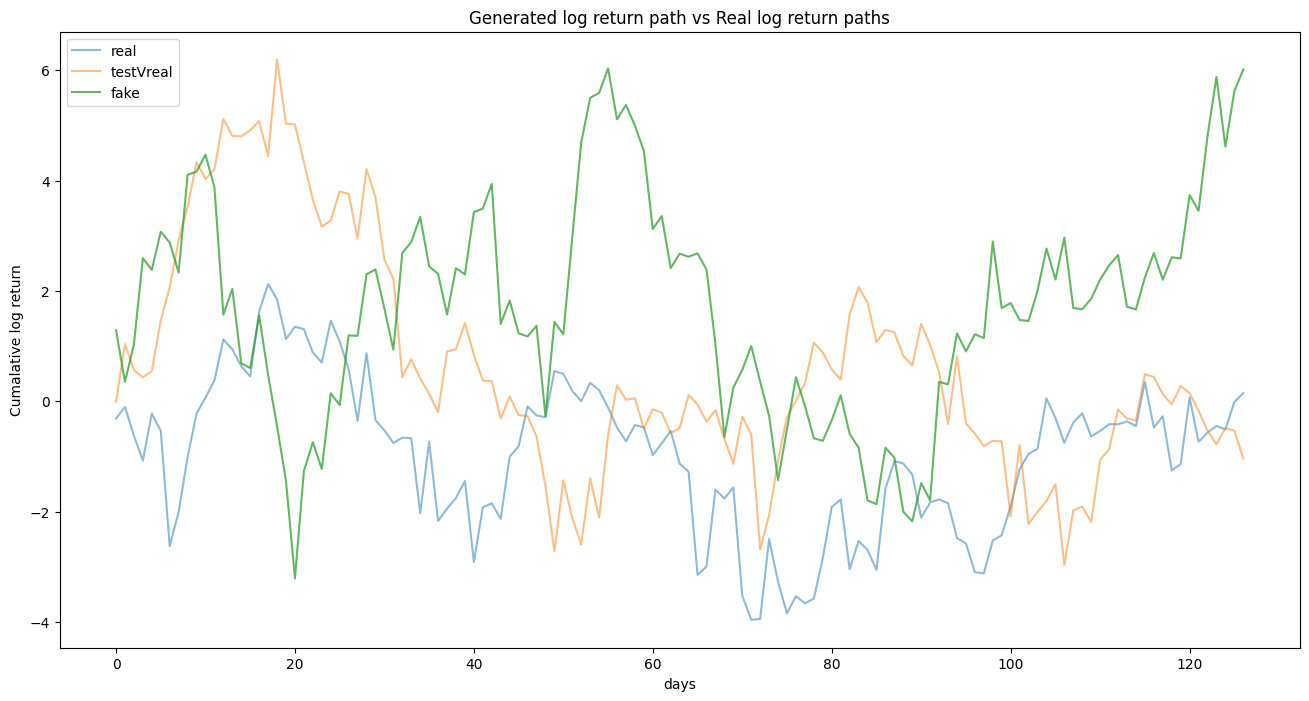

In [237]:
## For 1 feature
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(np.cumsum(log_returns_preprocessed_test.reshape(1, -1), axis=1).T, alpha=0.5, label='real')
ax.plot(np.cumsum(test_against_itself.reshape(1, -1), axis=1).T, alpha=0.5, label='testVreal')
#ax.plot(np.cumsum(y[best_i].reshape(1, -1), axis=1).T, alpha=0.75, label='fake')
ax.set_title('Generated log return path vs Real log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return')
ax.legend()

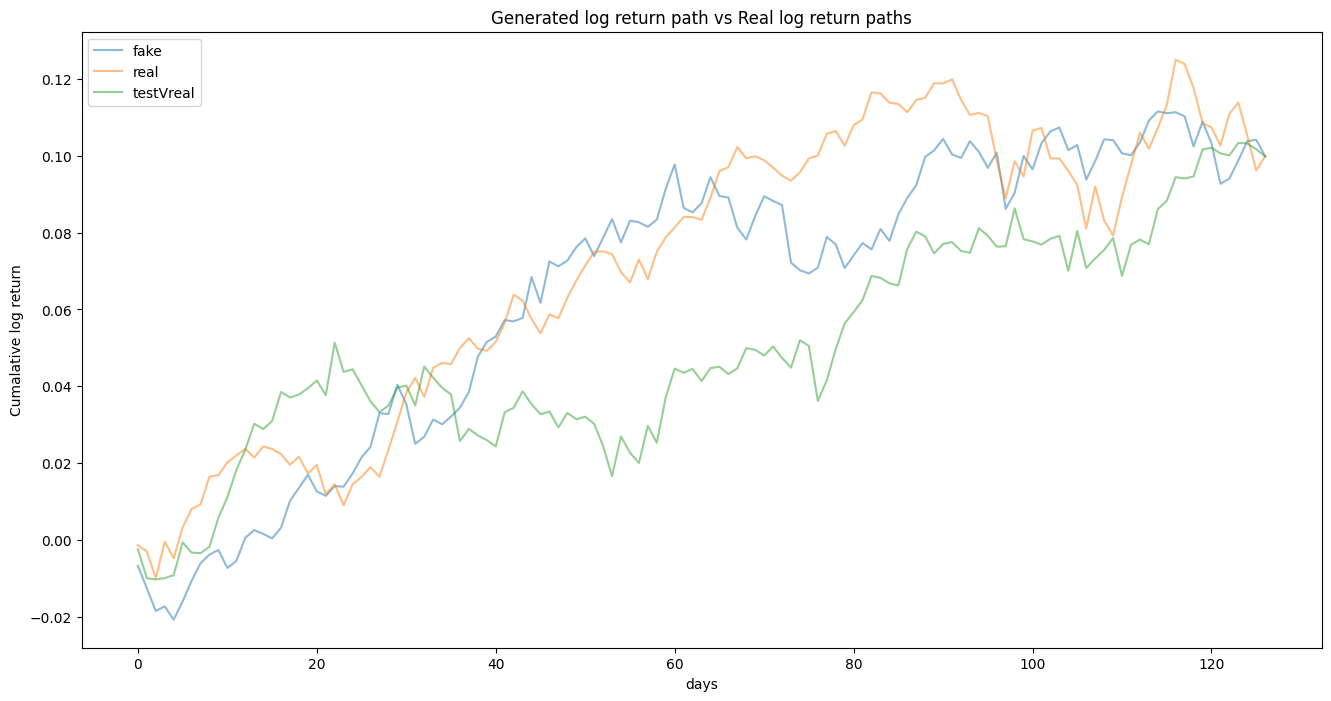

In [76]:
## For all features considering log returns and returns from price
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(np.cumsum(y[:,-1].reshape(1, -1), axis=1).T, alpha=0.5, label='fake')
ax.plot(np.cumsum(df_test[:,-1].reshape(1, -1), axis=1).T, alpha=0.5, label='real')
ax.plot(np.cumsum(df_test_against_itself[:,-1].reshape(1, -1), axis=1).T, alpha=0.5, label='testVreal')
ax.set_title('Generated log return path vs Real log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return')
ax.legend()

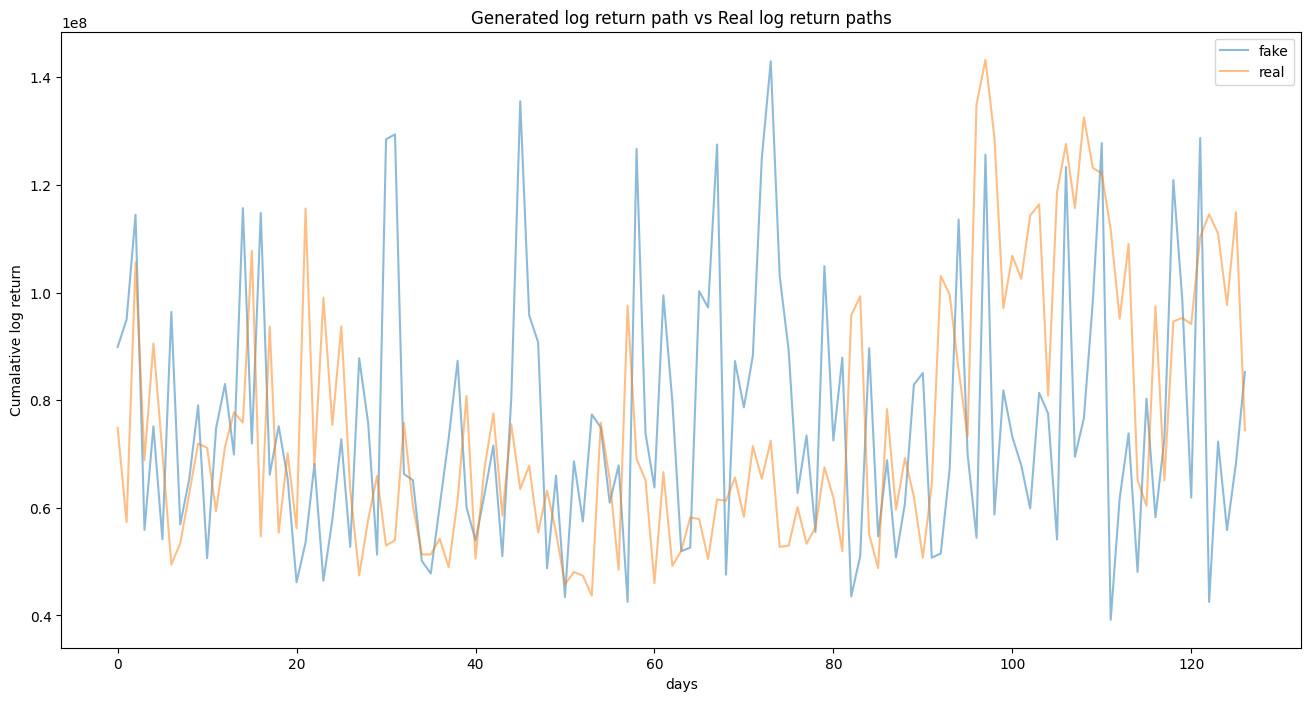

In [78]:
## For all features considering log returns and returns from price
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y[:,-2].reshape(1, -1).T, alpha=0.5, label='fake')
ax.plot(df_test[:,-2].reshape(1, -1).T, alpha=0.5, label='real')
#ax.plot(df_test_against_itself[:,-2].reshape(1, -1).T, alpha=0.5, label='testVreal')
ax.set_title('Generated log return path vs Real log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return')
ax.legend()

In [128]:
# Kutrosis & Skew for other features than lg_returns
from scipy.stats import skew, kurtosis
print(skew(df_test[:,3]))
print(skew(y[:,3]))
print(skew(df_test_against_itself[:,3]))
print(y.shape, df_test.shape)

print(kurtosis(df_test[:,3]))
print(kurtosis(y[:,3]))
print(kurtosis(df_test_against_itself[:,3]))

print(wasserstein_distance(y[:,-6], df_test[:,-6]))
print(wasserstein_distance(df_test_against_itself[:,-6], df_test[:,-6]))

0.04982245402139099
-0.9036663581956911
-0.14410424534542426
(127, 6) (127, 6)
-1.0399151213942985
-0.6518052752858239
-0.5112369840360977
9.517564343650982
3.031034757760378


## Selecting Best Generated path from QuantGAN using Wasserstein Distance

In [74]:
y.shape
log_returns_preprocessed_test.shape

(127, 1)

In [102]:
from scipy.stats import wasserstein_distance

In [210]:
#y[0].shape
#log_returns_preprocessed_test.reshape(-1)
#log_returns_preprocessed_train[200:388].reshape(-1).shape
#_, test_against_itself = train_test_split(log_returns_preprocessed, test_size=0.25, random_state=49)
wasserstein_distance(test_against_itself.reshape(-1), log_returns_preprocessed_test.reshape(-1))
#wasserstein_distance(y[15].T, log_returns_preprocessed_test.reshape(-1))
#len(y)

0.08460107629095341

In [169]:
windows = 2
rolling_window(y.T, windows, sparse = not (windows == 1)).mean(axis=0).shape
#rolling_window(log_returns_preprocessed_test.reshape(-1), windows, sparse = not (windows == 1)).mean(axis=0).ravel().shape

(126, 50)

In [218]:
# Finding Best path based on wasserstien distance
windows = [1, 5, 20, 100]
wassersteins_list = []

for i in range(len(windows)):
    real_dist = rolling_window(log_returns_preprocessed_test.reshape(-1), windows[i], sparse = not (windows[i] == 1)).mean(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).mean(axis=0)
    
    wassersteins = []
    for j in range(len(fake_dist.T)):
        wassersteins.append(wasserstein_distance(real_dist, fake_dist[:,j]))
        #print(len(wassersteins))
    wassersteins_list.append(wassersteins)

wassersteins_list = np.array(wassersteins_list)
print(np.sum(wassersteins_list, axis=0).shape)

best_i = np.argmin(np.sum(wassersteins_list, axis=0))
print(f'Best gen Path is y[{best_i}] with EMD = {wassersteins_list[:, best_i]}')


#best_wasserstein = wasserstein_distance(log_returns_preprocessed_test.reshape(-1), y[best_i].reshape(-1))
#print(f'best Wasserstein distance is: y[{best_i}] = {best_wasserstein} {wasserstein_distance(log_returns_preprocessed_test.reshape(-1), y[28].reshape(-1))}')

(50,)
Best gen Path is y[36] with EMD = [0.21425622 0.11915595 0.04196684 0.02567838]


In [109]:
0.13600948+ 0.09452303 +0.10099665 +0.10874444

0.4402736

In [38]:
wasserstein_distance(log_returns_preprocessed_test.reshape(-1), y[9].reshape(-1)) < wasserstein_distance(log_returns_preprocessed_test.reshape(-1), y[27].reshape(-1))

False

In [137]:
#fake_dist2 = rolling_window(y.T, 1, sparse=False).sum(axis=0).ravel()
#fake_dist2.shape
rolling_window(y[0:2].T, 5, sparse=True).sum(axis=0).ravel().shape
rolling_window(log_returns_preprocessed_test, 5, sparse=True).sum(axis=0).shape

(184, 1)

In [219]:


#normalized_log_returns_preprocessed_test = standardScaler2.inverse_transform(log_returns_preprocessed_test)
#normalized_log_returns_preprocessed_test = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in normalized_log_returns_preprocessed_test]).squeeze()
#normalized_log_returns_preprocessed_test = standardScaler1.inverse_transform(normalized_log_returns_preprocessed_test.reshape(-1,1))

windows = [1, 5, 20, 100]

best_gen_path = y[best_i]
#print(best_gen_path.shape)

for i in range(len(windows)):

    real_dist = rolling_window(log_returns_preprocessed_test.reshape(-1), windows[i], sparse = not (windows[i] == 1)).mean(axis=0).ravel()
    fake_dist = rolling_window(best_gen_path.T, windows[i], sparse = not (windows[i] == 1)).mean(axis=0).ravel()
    other_real_dist = rolling_window(test_against_itself.reshape(-1), windows[i], sparse = not (windows[i] == 1)).mean(axis=0).ravel()


    print(f'For window {windows[i]}, EMD_fake = {wasserstein_distance(real_dist, fake_dist)}')
    print(f'For window {windows[i]}, EMD_otherReal = {wasserstein_distance(real_dist, other_real_dist)}')
    #print(fake_dist[:10], real_dist[:10])
    #print('YOOOO', fake_dist.shape, real_dist.shape)

    #print(np.array([fake_dist, real_dist], dtype='object')[0][185:195])
    #print(fake_dist[185:195], y[0][185:], y[1][:5], )
    print('------x-------x----------')

For window 1, EMD_fake = 0.21425622002192185
For window 1, EMD_otherReal = 0.08460107629095341
------x-------x----------
For window 5, EMD_fake = 0.11915594904928678
For window 5, EMD_otherReal = 0.04735788189104406
------x-------x----------
For window 20, EMD_fake = 0.04196684192867047
For window 20, EMD_otherReal = 0.0352121358811719
------x-------x----------
For window 100, EMD_fake = 0.025678378334205342
For window 100, EMD_otherReal = 0.03283152867234387
------x-------x----------


Text(0.5, 0.98, 'QuantGAN_return_train SPY 2016-2019 return distribution')

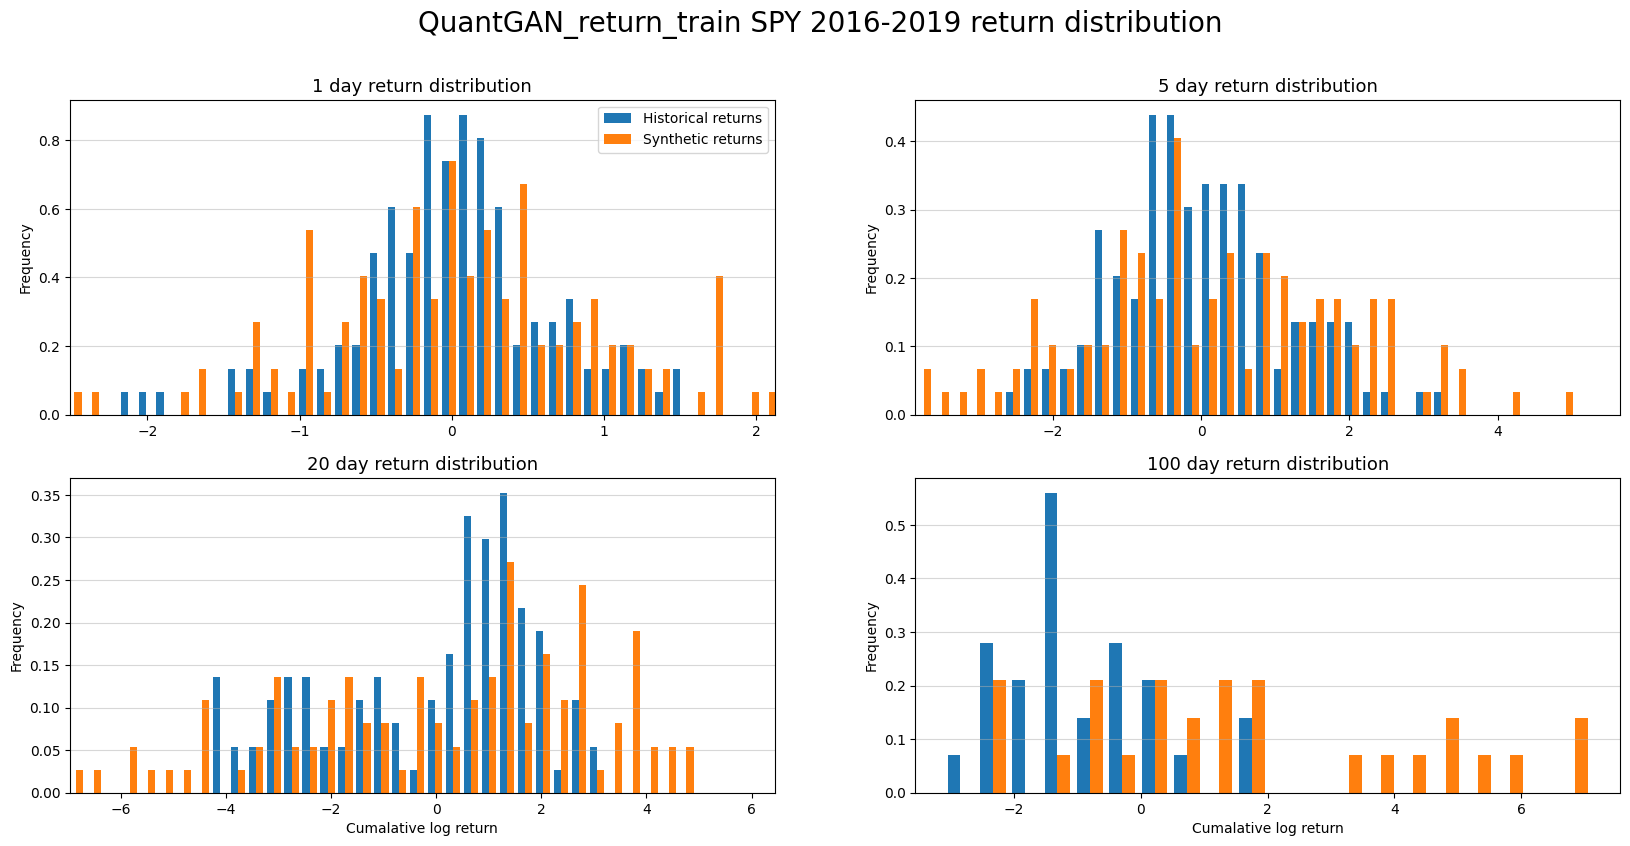

In [232]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 9))

best_gen_path = y[best_i]
#print(best_gen_path.shape)

for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    #row = i
    col = i % 2

    real_dist = rolling_window(log_returns_preprocessed_test.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(best_gen_path.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    other_real_dist = rolling_window(test_against_itself.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    #print(fake_dist.shape, real_dist.shape, log_returns_preprocessed_test.shape, best_gen_path.shape)
    #print('YO', np.array([real_dist, fake_dist], dtype='object')[0].shape)
    #print(log_returns_preprocessed_test[:10], real_dist[:10], fake_dist[:10])
    #print(y.T)
    #break
    
    #axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    #axs[row, 0].hist(real_dist, bins=25, density=True)
    #axs[row,0].set_xlim(*np.quantile(real_dist, [0.001, .999]))
    #axs[row, 1].hist(fake_dist, bins=25, density=False)
    #axs[row,1].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    if row == 1 and col == 1:
        axs[row, col].hist(np.stack([real_dist, fake_dist], axis=-1), bins=20, density=True)
        #axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    else:
        axs[row, col].hist(np.stack([real_dist, fake_dist], axis=-1), bins=40, density=True)
        axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=13)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    
    if row != 0:
        axs[row,col].set_xlabel('Cumalative log return')
    
    axs[row,col].set_ylabel('Frequency')
    #axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns', 'Other Historical'])
fig.suptitle('QuantGAN_return_train SPY 2016-2019 return distribution', fontsize=20)


Text(0.5, 0.98, 'Autocorrelation of time series dependency')

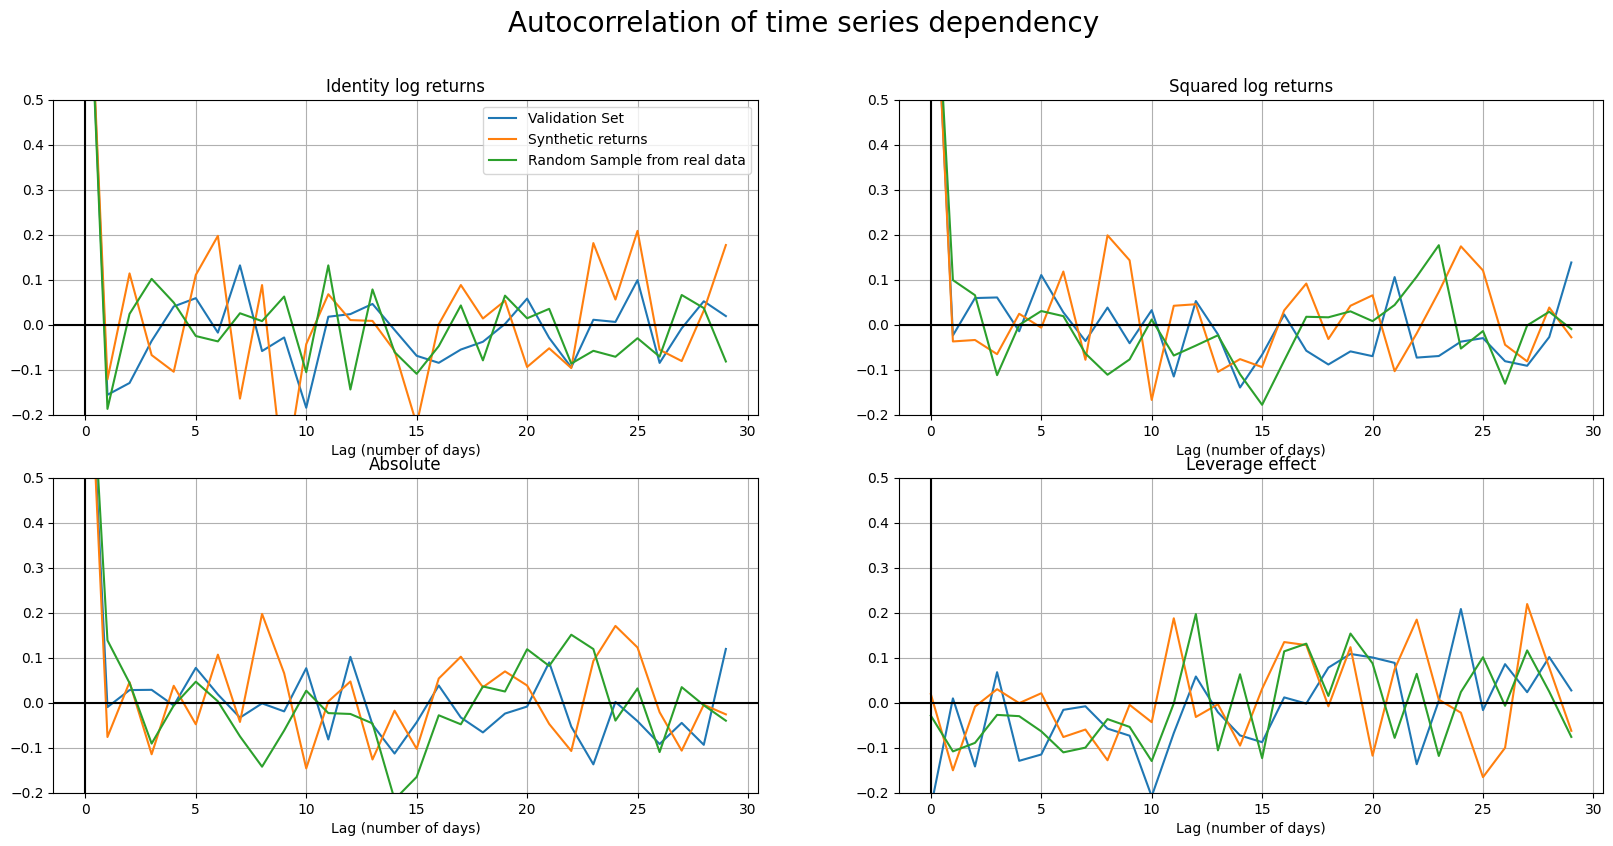

In [233]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 9))

axs[0,0].plot(acf(log_returns_preprocessed_test, 30))
axs[0,0].plot(acf(best_gen_path.T, 30))
axs[0,0].plot(acf(test_against_itself, 30))
axs[0,0].set_ylim(-0.2, 0.5)
axs[0,0].set_title('Identity log returns')

axs[0,1].plot(acf(log_returns_preprocessed_test**2, 30))
axs[0,1].plot(acf(best_gen_path.T**2, 30))
axs[0,1].plot(acf(test_against_itself**2, 30))
axs[0,1].set_ylim(-0.2, 0.5)
axs[0,1].set_title('Squared log returns')

axs[1,0].plot(acf(abs(log_returns_preprocessed_test), 30, le=False))
axs[1,0].plot(acf(abs(best_gen_path).T, 30, le=False))
axs[1,0].plot(acf(abs(test_against_itself), 30, le=False))
axs[1,0].set_ylim(-0.2, 0.5)

axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns_preprocessed_test, 30, le=True))
axs[1,1].plot(acf(best_gen_path.T, 30, le=True))
axs[1,1].plot(acf(test_against_itself, 30, le=True))
axs[1,1].set_ylim(-0.2, 0.5)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days)')
axs[0,0].legend(['Validation Set', 'Synthetic returns', 'Random Sample from real data'])
fig.suptitle('Autocorrelation of time series dependency', fontsize=20)

In [234]:
import math

def acf_score(x, y, k):
    #print(acf(x, k).shape, acf(y, k).shape)
    
    acf_r = (acf(x, k) - acf(y, k))**2 #Retrun ACF
    print(f'ACF_r = {math.sqrt(acf_r.mean())}')

    acf_abs_r = (acf(abs(x), k) - acf(abs(y), k))**2 #Absolute ACF
    print(f'ACF_|r| = {math.sqrt(acf_abs_r.mean())}')
    
    acf_sq_r = (acf(x**2, k) - acf(y**2, k))**2 #Sqr ACF
    print(f'ACF_r^2 = {math.sqrt(acf_sq_r.mean())}')
    
    acf_le = (acf(x, k, le=True) - acf(y, k, le=True))**2 #Leverage Effect
    print(f'Leverege Effect = {math.sqrt(acf_le.mean())}')
    
    return math.sqrt(acf_r.mean() + acf_abs_r.mean() + acf_sq_r.mean() + acf_le.mean())


print(acf_score(log_returns_preprocessed_test.reshape(-1), best_gen_path.T, len(log_returns_preprocessed_test)-1))
print(acf_score(log_returns_preprocessed_test.reshape(-1), test_against_itself.reshape(-1), len(log_returns_preprocessed_test)-1))



ACF_r = 0.14289209862412422
ACF_|r| = 0.12728748821053246
ACF_r^2 = 0.13588425136340568
Leverege Effect = 0.15487391721619975
0.28119515733140993
ACF_r = 0.11657279629969958
ACF_|r| = 0.1135142673509955
ACF_r^2 = 0.11419663638233486
Leverege Effect = 0.13029141414377912
0.23767925885526803


# Finding Best path based on wasserstien distance
best_i = 0
for i in range(len(y)):
    if wasserstein_distance(log_returns_preprocessed_test.reshape(-1), y[i].reshape(-1)) < wasserstein_distance(log_returns_preprocessed_test.reshape(-1), y[best_i].reshape(-1)):
        best_i = i

best_wasserstein = wasserstein_distance(log_returns_preprocessed_test.reshape(-1), y[best_i].reshape(-1))
print(f'best Wasserstein distance is: y[{best_i}] = {best_wasserstein}')

### K-S Test

In [239]:
print(stats.kstest(log_returns_preprocessed_test.reshape(-1), best_gen_path.T))
print(stats.kstest(log_returns_preprocessed_test.reshape(-1), test_against_itself.reshape(-1)))
print(stats.kstest(log_returns_preprocessed_test.reshape(-1), log_returns_preprocessed_test.reshape(-1)))

KstestResult(statistic=0.13385826771653545, pvalue=0.20571236927761824)
KstestResult(statistic=0.09448818897637795, pvalue=0.624189580277946)
KstestResult(statistic=0.0, pvalue=1.0)
